# Manual Evaluation Explorer

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from textwrap import wrap
import matplotx

all_columns = [
  "problem",
  "problem_agreement",
  "objective",
  "objective_agreement",
  "research_method",
  "research_method_agreement",
  "research_questions",
  "research_questions_agreement",
  "pseudocode",
  "pseudocode_agreement",
  "dataset",
  "dataset_agreement",
  "hypothesis",
  "hypothesis_agreement",
  "prediction",
  "prediction_agreement",
  "code_available",
  "code_available_agreement",
  "software_dependencies",
  "software_dependencies_agreement",
  "experiment_setup",
  "experiment_setup_agreement"
]
metric_columns = [col for col in all_columns if not col.endswith("_agreement")]
metrics_display_map = {
    "experiment_setup": "Experimental setup",
    "hypothesis": "Hypothesis",
    "code_available": "Code available",
    "objective": "Objective/ Goal",
    "prediction": "Prediction",
    "problem": "Research problem",
    "pseudocode": "Pseudocode",
    "research_method": "Research method",
    "research_questions": "Research questions",
    "dataset": "Dataset",
    "software_dependencies": "Software dependencies",
}
metric_order = [
        "problem", "objective", "research_method", "research_questions",
        "pseudocode", "dataset", "hypothesis", "prediction",
        "code_available", "software_dependencies", "experiment_setup"
    ]

In [2]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_dir = '/mnt/c/Users/adb/Desktop/stuff/fonts/'
font_name = 'IBMPlexSans-Regular.ttf'
font_name = 'Inter-Regular.ttf'
# font_name = 'FiraSans-Regular.ttf'
font_manager.fontManager.addfont(font_dir + font_name)
prop = font_manager.FontProperties(fname=font_dir + font_name)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [3]:
df_manuscript_manual = pd.read_csv("https://huggingface.co/datasets/adbX/reproscreener_manual_evaluations/resolve/main/manuscript.csv")
df_manuscript_manual.set_index("paper_id", inplace=True)
df_manuscript_manual = df_manuscript_manual.drop(
    columns=["evaluation_type", "source_file"]
    + [col for col in df_manuscript_manual.columns if "_description" in col]
)
df_manuscript_manual = df_manuscript_manual.rename(columns={"code_available_in_article": "code_available"})
df_manuscript_manual.head()

,paper_url,notes,empirical_dataset,code_available,papers_with_code_link_available,papers_with_code_link_matches,result_replication_code_available,is_package,has_wrapper_scripts,hardware_specifications_provided,...,will_it_reproduce_desc,problem,objective,research_method,research_questions,pseudocode,dataset,hypothesis,prediction,experiment_setup
paper_id,,,,,,,,,,,,,,,,,,,,,
1606.04671,https://arxiv.org/pdf/1606.04671.pdf,No code or data released,NaN,False,False,False,NaN,NaN,False,NaN,...,NaN,False,False,False,False,False,False,False,False,True
1903.09668,https://arxiv.org/pdf/1903.09668.pdf,No code or data released,NaN,False,False,False,NaN,NaN,False,NaN,...,NaN,False,False,False,False,True,False,False,False,True
1904.10554,https://arxiv.org/pdf/1904.10554.pdf,No code or data released,NaN,False,False,False,NaN,NaN,False,NaN,...,NaN,False,False,False,False,True,False,False,False,True
1908.05659,https://arxiv.org/pdf/1908.05659.pdf,"90 page review, no experiments, mostly math",NaN,False,False,False,NaN,NaN,False,NaN,...,NaN,False,False,False,False,False,False,False,False,False
1909.00931,https://arxiv.org/pdf/1909.00931.pdf,NaN,NaN,True,True,True,NaN,NaN,False,True,...,NaN,True,False,False,False,True,True,True,False,True


## Reproscreener (regex) vs. Manual evaluations of full manuscripts

In [4]:
df_manuscript_regex = pd.read_csv("https://huggingface.co/datasets/adbX/reproscreener_manual_evaluations/resolve/main/repro_eval_tex.csv")
df_manuscript_regex = df_manuscript_regex.rename(columns={"method_source_code": "code_available", "id": "paper_id"})
df_manuscript_regex.set_index("paper_id", inplace=True)
df_manuscript_regex['dataset'] = df_manuscript_regex['training_data'].astype(bool) + df_manuscript_regex['test_data'].astype(bool) + df_manuscript_regex['validation_data'].astype(bool) + df_manuscript_regex['training_data'].astype(bool)
df_manuscript_regex = df_manuscript_regex.drop(columns=["index","training_data", "test_data", "validation_data", "title"])
df_manuscript_regex[metric_columns] = df_manuscript_regex[metric_columns].astype(bool)

In [5]:
# Align indices across manual and regex dataframes and compute agreement
common_idx = df_manuscript_manual.index.intersection(df_manuscript_regex.index)
manual_bool = df_manuscript_manual.loc[common_idx, metric_columns].astype(bool)
regex_bool = df_manuscript_regex.loc[common_idx, metric_columns].astype(bool)

results_manuscript = {}
for manuscript_metric in metric_columns:
    manuscript_regex_vals = regex_bool[manuscript_metric]
    manuscript_manual_vals = manual_bool[manuscript_metric]

    results_manuscript[manuscript_metric] = {
        'regex_sum': int(manuscript_regex_vals.sum()),
        'manual_sum': int(manuscript_manual_vals.sum()),
        'regex_proportion': float(manuscript_regex_vals.mean()),
        'regex_manual_agreement': float((manuscript_regex_vals == manuscript_manual_vals).mean()),
        'manual_proportion': float(manuscript_manual_vals.mean()),
        'total_n': int(len(manuscript_regex_vals))
    }

manuscript_results_df = pd.DataFrame(results_manuscript).T

tab_decimal_manu = manuscript_results_df
tab_percent_manu = manuscript_results_df.copy()
tab_percent_manu['regex_proportion'] = tab_percent_manu['regex_proportion'].mul(100).round(0).astype(int).astype(str).add('%')
tab_percent_manu['manual_proportion'] = tab_percent_manu['manual_proportion'].mul(100).round(0).astype(int).astype(str).add('%')
tab_percent_manu['regex_manual_agreement'] = tab_percent_manu['regex_manual_agreement'].mul(100).round(0).astype(int).astype(str).add('%')

# tabs_manu = mo.ui.tabs({"percent": tab_percent_manu, "decimal": tab_decimal_manu})
tab_percent_manu

,regex_sum,manual_sum,regex_proportion,regex_manual_agreement,manual_proportion,total_n
problem,44.0,15.0,88%,38%,30%,50.0
objective,39.0,4.0,78%,30%,8%,50.0
research_method,43.0,10.0,86%,30%,20%,50.0
research_questions,45.0,3.0,90%,16%,6%,50.0
pseudocode,7.0,22.0,14%,62%,44%,50.0
dataset,19.0,31.0,38%,48%,62%,50.0
hypothesis,21.0,8.0,42%,62%,16%,50.0
prediction,34.0,0.0,68%,32%,0%,50.0
code_available,23.0,22.0,46%,82%,44%,50.0
software_dependencies,0.0,14.0,0%,72%,28%,50.0


## Reproscreener (regex) vs. Manual evaluations of abstracts

In [6]:
# Load regex results for abstracts computed locally
df_abstract_regex = pd.read_csv("../reports/tables/abstract_regex_gs.csv")
df_abstract_regex = df_abstract_regex.set_index("paper_id")
# Ensure boolean dtype for metrics
available_cols = [c for c in metric_columns if c in df_abstract_regex.columns]
df_abstract_regex[available_cols] = df_abstract_regex[available_cols].astype(bool)
df_abstract_regex.head()

,problem,objective,research_method,research_questions,pseudocode,dataset,hypothesis,prediction,code_available,software_dependencies,experiment_setup
paper_id,,,,,,,,,,,
1606.04671,False,False,False,False,False,False,False,False,False,False,False
1903.09668,False,False,True,True,False,False,False,True,False,False,False
1904.10554,False,False,False,True,False,False,False,False,False,False,False
1908.05659,False,False,False,True,False,False,False,False,False,False,False
1909.00931,False,False,True,True,False,False,False,False,False,False,False


In [7]:
# Load GPT agreement for abstracts and derive manual columns from agreement
df_abs_gpt_agreement = pd.read_csv("https://huggingface.co/datasets/adbX/reproscreener_manual_evaluations/resolve/main/agreement_gpt.csv")

# Clean up columns - exclude metadata and description columns
df_abs_gpt_agreement = df_abs_gpt_agreement.set_index("paper_id")
df_abs_gpt_agreement = df_abs_gpt_agreement.drop(
    columns=["evaluation_type", "source_file"]
    + [col for col in df_abs_gpt_agreement.columns if "_description" in col]
)

# Remove gpt_ prefix from column names
df_abs_gpt_agreement = df_abs_gpt_agreement.rename(
    columns={
        col: col.replace("gpt_", "")
        for col in df_abs_gpt_agreement.columns
        if col.startswith("gpt_")
    }
)

# Compute manual_<metric> using agreement flip rule
for abs_metric in metric_columns:
    abs_agreement_col = f"{abs_metric}_agreement"
    if abs_metric in df_abs_gpt_agreement.columns and abs_agreement_col in df_abs_gpt_agreement.columns:
        abs_gpt_vals = df_abs_gpt_agreement[abs_metric].astype(bool)
        abs_agreement_vals = df_abs_gpt_agreement[abs_agreement_col]
        abs_manual_vals = np.where(abs_agreement_vals == 1, abs_gpt_vals, ~abs_gpt_vals)
        df_abs_gpt_agreement[f"manual_{abs_metric}"] = abs_manual_vals.astype(bool)

In [8]:
# Build manual abstract evaluations from df_abs_gpt_agreement manual_ columns
abs_manual_cols_map = {
    f"manual_{m}": m for m in metric_columns if f"manual_{m}" in df_abs_gpt_agreement.columns
}
df_abstract_manual = df_abs_gpt_agreement[list(abs_manual_cols_map.keys())].rename(columns=abs_manual_cols_map)
# Ensure boolean dtype
df_abstract_manual = df_abstract_manual.astype(bool)

In [9]:
# Align indices and compute agreement for abstracts
common_idx_abs = df_abstract_manual.index.intersection(df_abstract_regex.index)
manual_bool_abs = df_abstract_manual.loc[common_idx_abs]
regex_bool_abs = df_abstract_regex.loc[common_idx_abs]

# abstract_metrics = [m for m in metric_columns if m in manual_bool_abs.columns and m in regex_bool_abs.columns]

results_abs = {}
for metric in metric_columns:
    regex_vals = regex_bool_abs[metric].astype(bool)
    manual_vals = manual_bool_abs[metric].astype(bool)

    results_abs[metric] = {
        'regex_sum': int(regex_vals.sum()),
        'manual_sum': int(manual_vals.sum()),
        'regex_proportion': float(regex_vals.mean()),
        'regex_manual_agreement': float((regex_vals == manual_vals).mean()),
        'manual_proportion': float(manual_vals.mean()),
        'total_n': int(len(regex_vals)),
    }

abstract_results_regex_df = pd.DataFrame(results_abs).T

tab_decimal_abs = abstract_results_regex_df
tab_percent_abs = abstract_results_regex_df.copy()
tab_percent_abs['regex_proportion'] = tab_percent_abs['regex_proportion'].mul(100).round(0).astype(int).astype(str).add('%')
tab_percent_abs['manual_proportion'] = tab_percent_abs['manual_proportion'].mul(100).round(0).astype(int).astype(str).add('%')
tab_percent_abs['regex_manual_agreement'] = tab_percent_abs['regex_manual_agreement'].mul(100).round(0).astype(int).astype(str).add('%')

tab_percent_abs

,regex_sum,manual_sum,regex_proportion,regex_manual_agreement,manual_proportion,total_n
problem,12.0,41.0,24%,38%,82%,50.0
objective,4.0,44.0,8%,20%,88%,50.0
research_method,20.0,22.0,40%,56%,44%,50.0
research_questions,13.0,4.0,26%,70%,8%,50.0
pseudocode,0.0,0.0,0%,100%,0%,50.0
dataset,1.0,6.0,2%,86%,12%,50.0
hypothesis,0.0,6.0,0%,88%,12%,50.0
prediction,4.0,9.0,8%,82%,18%,50.0
code_available,2.0,4.0,4%,96%,8%,50.0
software_dependencies,0.0,1.0,0%,98%,2%,50.0


## GPT-4 vs. Manual evaluations of manuscript abstracts

In [10]:
df_gpt_agreement_manu = pd.read_csv("https://huggingface.co/datasets/adbX/reproscreener_manual_evaluations/resolve/main/agreement_gpt.csv")

# Clean up columns - exclude metadata and description columns
# Make "paper_id" the index
df_gpt_agreement_manu = df_gpt_agreement_manu.set_index("paper_id")

df_gpt_agreement_manu = df_gpt_agreement_manu.drop(
    columns=["evaluation_type", "source_file"]
    + [col for col in df_gpt_agreement_manu.columns if "_description" in col]
)

# Remove gpt_ prefix from column names
df_gpt_agreement_manu = df_gpt_agreement_manu.rename(
    columns={
        col: col.replace("gpt_", "")
        for col in df_gpt_agreement_manu.columns
        if col.startswith("gpt_")
    }
)

results = {}
for manu_metric in metric_columns:
    gpt_col = manu_metric
    agreement_col = f"{manu_metric}_agreement"

    if agreement_col in df_gpt_agreement_manu.columns:
        gpt_vals = df_gpt_agreement_manu[gpt_col].astype(bool)
        agreement_vals = df_gpt_agreement_manu[agreement_col]

        # Calculate revised manual evaluation: keep GPT when agreement=1, invert when agreement=0
        manual_vals_gpt_abs = np.where(agreement_vals == 1, gpt_vals, ~gpt_vals)

        # Add manual_vals_gpt_abs to the agreement_gpt DataFrame
        df_gpt_agreement_manu[f"manual_{manu_metric}"] = manual_vals_gpt_abs.astype(bool)

        results[manu_metric] = {
            'gpt_sum': gpt_vals.sum(),
            'manual_sum': manual_vals_gpt_abs.sum(),
            'gpt_proportion': gpt_vals.mean(),
            'gpt_manual_agreement': agreement_vals.mean(),
            'manual_proportion': manual_vals_gpt_abs.mean(),
            'total_n': len(gpt_vals)
        }
abstract_results_gpt4_df = pd.DataFrame(results).T

tab_decimal = abstract_results_gpt4_df
tab_percent = abstract_results_gpt4_df.copy()
tab_percent['gpt_proportion'] = tab_percent['gpt_proportion'].mul(100).round(0).astype(int).astype(str).add('%')
tab_percent['manual_proportion'] = tab_percent['manual_proportion'].mul(100).round(0).astype(int).astype(str).add('%')
tab_percent['gpt_manual_agreement'] = tab_percent['gpt_manual_agreement'].mul(100).round(0).astype(int).astype(str).add('%')

# tabs = mo.ui.tabs({"percent": tab_percent, "decimal": tab_decimal})
tab_percent

,gpt_sum,manual_sum,gpt_proportion,gpt_manual_agreement,manual_proportion,total_n
problem,49.0,41.0,98%,80%,82%,50.0
objective,49.0,44.0,98%,86%,88%,50.0
research_method,47.0,22.0,94%,46%,44%,50.0
research_questions,4.0,4.0,8%,96%,8%,50.0
pseudocode,0.0,0.0,0%,100%,0%,50.0
dataset,14.0,6.0,28%,68%,12%,50.0
hypothesis,6.0,6.0,12%,88%,12%,50.0
prediction,25.0,9.0,50%,52%,18%,50.0
code_available,4.0,4.0,8%,100%,8%,50.0
software_dependencies,1.0,1.0,2%,100%,2%,50.0


In [11]:
# Load LLaMA 3.2 abstract results
df_abstract_llama32 = pd.read_csv("../../llama3/outputs_json/20250829-235938/analysis_summary_reproscreener.csv")
df_abstract_llama32 = df_abstract_llama32.set_index("paper_id")
# Ensure boolean dtype for metrics present in this dataframe
available_cols_llama32 = [c for c in metric_columns if c in df_abstract_llama32.columns]
df_abstract_llama32[available_cols_llama32] = df_abstract_llama32[available_cols_llama32].astype(bool)
# df_abstract_llama32.apply(lambda x: x.value_counts())
common_idx_abs_llama32 = df_abstract_manual.index.intersection(df_abstract_llama32.index)
manual_bool_abs_llama32 = df_abstract_manual.loc[common_idx_abs_llama32]
llama32_bool_abs = df_abstract_llama32.loc[common_idx_abs_llama32]

metrics_llama32_shared = [
    m for m in metric_columns
    if m in manual_bool_abs_llama32.columns and m in llama32_bool_abs.columns
]

results_abs_llama32 = {}
for metric_llama32 in metrics_llama32_shared:
    llama32_vals = llama32_bool_abs[metric_llama32].astype(bool)
    manual_vals_llama32 = manual_bool_abs_llama32[metric_llama32].astype(bool)

    results_abs_llama32[metric_llama32] = {
        'llama32_sum': int(llama32_vals.sum()),
        'manual_sum_llama32': int(manual_vals_llama32.sum()),
        'llama32_proportion': float(llama32_vals.mean()),
        'llama32_manual_agreement': float((llama32_vals == manual_vals_llama32).mean()),
        'manual_proportion_llama32': float(manual_vals_llama32.mean()),
        'total_n_llama32': int(len(llama32_vals)),
    }

abstract_results_llama32_df = pd.DataFrame(results_abs_llama32).T

tab_decimal_abs_llama32 = abstract_results_llama32_df
tab_percent_abs_llama32 = abstract_results_llama32_df.copy()
tab_percent_abs_llama32['llama32_proportion'] = tab_percent_abs_llama32['llama32_proportion'].mul(100).round(0).astype(int).astype(str).add('%')
tab_percent_abs_llama32['manual_proportion_llama32'] = tab_percent_abs_llama32['manual_proportion_llama32'].mul(100).round(0).astype(int).astype(str).add('%')
tab_percent_abs_llama32['llama32_manual_agreement'] = tab_percent_abs_llama32['llama32_manual_agreement'].mul(100).round(0).astype(int).astype(str).add('%')

tab_percent_abs_llama32

,llama32_sum,manual_sum_llama32,llama32_proportion,llama32_manual_agreement,manual_proportion_llama32,total_n_llama32
problem,41.0,41.0,82%,72%,82%,50.0
objective,14.0,44.0,28%,36%,88%,50.0
research_method,7.0,22.0,14%,54%,44%,50.0
research_questions,7.0,4.0,14%,86%,8%,50.0
pseudocode,0.0,0.0,0%,100%,0%,50.0
dataset,1.0,6.0,2%,90%,12%,50.0
hypothesis,2.0,6.0,4%,84%,12%,50.0
prediction,5.0,9.0,10%,80%,18%,50.0
code_available,3.0,4.0,6%,98%,8%,50.0
software_dependencies,0.0,1.0,0%,98%,2%,50.0


In [12]:
import matplotlib.pyplot as plt

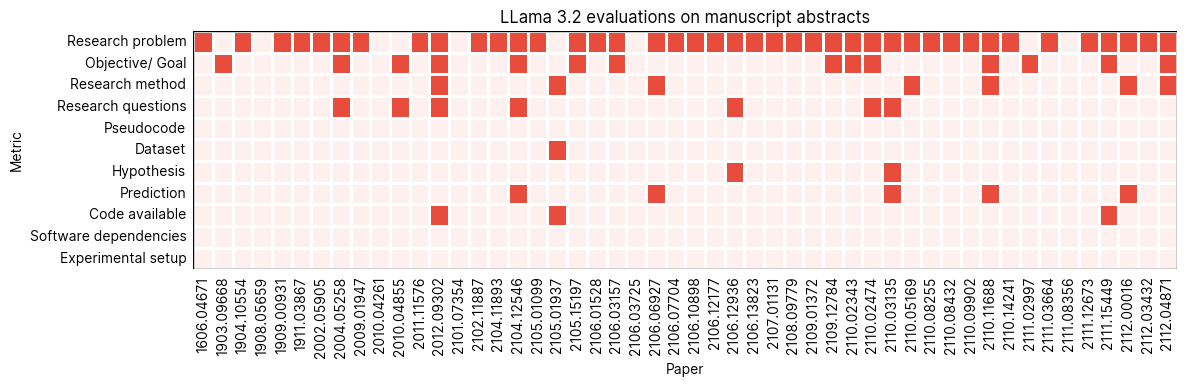

In [13]:
def plot_heatmap_llama(metrics_display_map):
    # Metrics on rows, papers on columns
    heatmap_df = df_abstract_llama32.astype(float).T
    heatmap_df.index = [metrics_display_map.get(m, m.replace("_", " ").title()) for m in heatmap_df.index]

    # Two-color scheme (empty, filled)
    custom_cmap = ListedColormap(["#FFF0F0", "#E74C3C"])

    fig, ax = plt.subplots(figsize=(12, 4), tight_layout={"pad": 1.5})

    # Black frame
    ax.axhline(y=0, color="k", linewidth=1)
    ax.axvline(x=0, color="k", linewidth=1)
    ax.axhline(y=heatmap_df.shape[0], color="k", linewidth=1)
    ax.axvline(x=heatmap_df.shape[1], color="k", linewidth=1)

    sns.heatmap(heatmap_df, cmap=custom_cmap, cbar=False, linewidths=1, ax=ax)

    ax.set(xlabel="Paper", ylabel="Metric")
    plt.title("LLama 3.2 evaluations on manuscript abstracts")
    plt.subplots_adjust(top=0.95, left=0.15, right=0.95)
    plt.tight_layout()
    plt.tick_params(axis='both', size=0, pad=5)
    # Optional:
    plt.savefig("../reports/figures/hm_abstract_llama32.png", dpi=320, bbox_inches="tight")
    plt.show()

plot_heatmap_llama(metrics_display_map)

## Abstract evaluation comparison

In [14]:
# plot all 3 agreement metrics
abstract_results_regex_df.regex_manual_agreement
abstract_results_gpt4_df.gpt_manual_agreement
abstract_results_llama32_df.llama32_manual_agreement

merged_agreement_results = pd.DataFrame({
    'Reproscreener (regex)': abstract_results_regex_df['regex_manual_agreement'],
    'GPT-4': abstract_results_gpt4_df['gpt_manual_agreement'],
    'LLaMA 3.2': abstract_results_llama32_df['llama32_manual_agreement']
})
merged_agreement_results.index.name = 'Metric'
merged_agreement_results_melt = merged_agreement_results.reset_index().melt(id_vars='Metric', var_name='Method', value_name='Agreement')
merged_agreement_results

,Reproscreener (regex),GPT-4,LLaMA 3.2
Metric,,,
problem,0.38,0.80,0.72
objective,0.20,0.86,0.36
research_method,0.56,0.46,0.54
research_questions,0.70,0.96,0.86
pseudocode,1.00,1.00,1.00
dataset,0.86,0.68,0.90
hypothesis,0.88,0.88,0.84
prediction,0.82,0.52,0.80
code_available,0.96,1.00,0.98


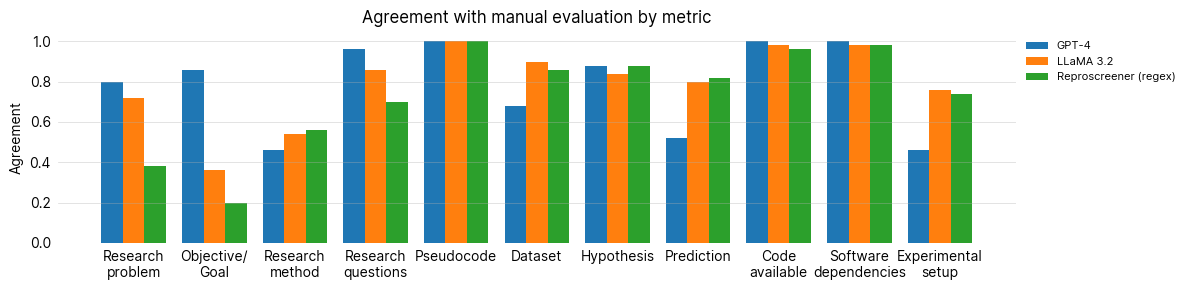

In [17]:
def plot_agreement_by_metric_mpl(metrics_display_map, metric_order):
    df_sorted = merged_agreement_results_melt.sort_values(["Metric","Method"])
    methods = df_sorted["Method"].unique()
    
    x = np.arange(len(metric_order))
    width = 0.8 / len(methods)

    fig, ax = plt.subplots(figsize=(12, 3))
    for i, m in enumerate(methods):
        sub = df_sorted[df_sorted["Method"] == m].set_index("Metric").reindex(metric_order)
        ax.bar(x + i*width - (len(methods)-1)*width/2, sub["Agreement"].values, width, label=m)

    ax.set_xticks(x)
    ax.set_xticklabels([ "\n".join(wrap(metrics_display_map[m], 12)) for m in metric_order ])
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Agreement")
    ax.set_title("Agreement with manual evaluation by metric")
    ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.5)
    ax.tick_params(axis="x", size=0, pad=5)
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
    ax.tick_params(axis="y", size=0, pad=5)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8, frameon=False)
    plt.tight_layout()
    plt.savefig("../reports/figures/agreement_by_metric.png", dpi=320, bbox_inches="tight")
    plt.show()
plot_agreement_by_metric_mpl(metrics_display_map, metric_order)